# Sujet d'une lettre
Identifier le.s sujet.s d'un document, comparer la similarité de deux documents en terme de sujet

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import word2vec
from scipy.spatial import distance

In [2]:
# Import data
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

In [15]:
df[df.question.str.contains('afnor')].titre

1778                        application norme nf z74 - 501
6249          uniformisation européen clavier informatique
6913     négociation cours filière opticien santé rac zéro
6932                     reste charge zéro matière optique
6946     négociation opticien conséquence dispositif ra...
6983                  reste charge zéro équipement optique
6991     évolution négociation cours filière opticien s...
6997                             reste charge zéro optique
7029                                   inquiétude opticien
7053                     reste charge zéro matière optique
7486                situation opticien - reste charge zéro
7646                      avenir profession opticien santé
7716                             reste charge zéro optique
7734                                filière opticien santé
7983                            avis internet e-réputation
8065                                       filière optique
8184     évolution négociation cours filière opticien s.

## 1. Average Vector of we 
Calculer une similarité des titres et phrases en fonction de la distance entre la somme de leur représentation vectorielle. Voir cette [explication pratique](https://freecontent.manning.com/sentence-classification-in-nlp/)

In [6]:
# Load le model,  voir WE et https://github.com/danielfrg/word2vec/blob/master/examples/word2vec.ipynb
model = word2vec.load('../data/frWac_non_lem_no_postag_no_phrase_200_skip_cut100.bin')
# Dimension du modèle
_,dim = model.vectors.shape  

In [6]:
# Fonctions de comparaison de similarité
# Transforme un mot en vecteur, si il n'est pas reconnu on renvoit un vecteur de 0
def to_vec(mot,print_err = False):
    try : 
        return model[mot]
    except Exception as e:
        if print_err:
            print(type(e),e )
        return np.zeros(dim)
        
# Somme les vecteurs d'une phrase, si il y a un problème on retourne -1
def sum_we(phrase,print_err = True)):
    try:
        return sum([ to_vec(mot)for mot in phrase.split(' ')])
    except Exception as e:
        if print_err:
            print(type(e),e ):
        return -1

# Retourne la mesure de similarité : 1 - (distance des deux sommes de mots en vecteurs)
def sim_sum_vec(a,b):
    return 1 - distance.cosine(sum_we(a),sum_we(b))

### 1.1 Sur les titres

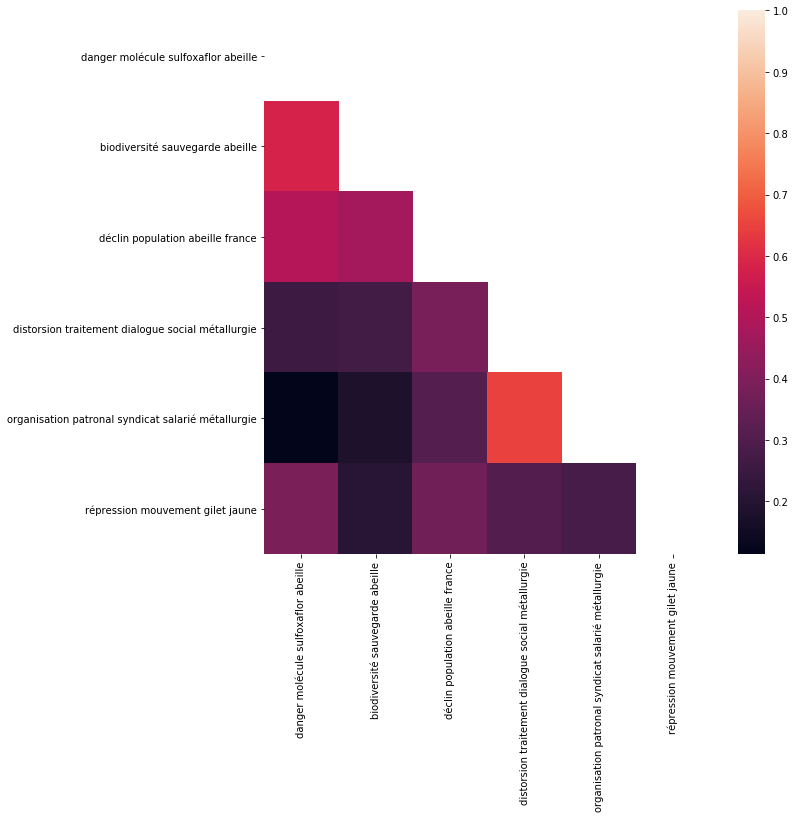

In [7]:
# On prend quelques questions sur les abeilles
index_abeilles = df.titre.str.contains('abeille')
abeilles = df[index_abeilles].titre[:3]

# On prend quelques questions sur l'industrie
index_metal = df.titre.str.contains('métallurgie')
metal = df[index_metal].titre[:2]

# Et une sur les gilets jaunes
index_jaune = df.titre.str.contains('gilet jaune')
jaune = df[index_jaune].titre[:1]

titres = list(abeilles) + list(metal) + list(jaune)

mat = [[sim_sum_vec(a,b) for a in titres] for b in titres]

# Affichage
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(mat) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(mat,ax = ax, xticklabels=titres, yticklabels=titres,mask=mask);

In [95]:
# Tri des lettres pour leur proximité avec titres[0]
df.loc[df.titre.apply(lambda x : sim_sum_vec(x,titres[0])).sort_values(ascending = False).index].head()

,uid,date_question,date_reponse,groupe_auteur,ministere_adresse,question,rubrique,titre,ref_auteur,nom_auteur
2641,QANR5L15QE2708,2017-11-07,2018-02-13,FI,Ministère de la transition écologique et solid...,m. jean-luc mélenchon attire attention m. mini...,produits dangereux,danger molécule sulfoxaflor abeille,PA2150,jean-luc mélenchon
25307,QANR5L15QE25301,2019-12-17,2020-01-28,MODEM,Ministère des solidarités et de la santé,mme élodie jacquier - laforge interroger mme m...,produits dangereux,danger fongicide inhibiteur succinate déshydro...,PA719874,élodie jacquier
10184,QANR5L15QE10014,2018-07-03,2018-11-13,LAREM,Ministère de la transition écologique et solid...,mme jacqueline maquet interroger m. ministre é...,agriculture,disparition abeille,PA334116,jacqueline maquet
5110,QANR5L15QE5188,2018-02-06,2018-04-10,LAREM,Ministère de la transition écologique et solid...,m. jean-michel clément attire attention m. min...,produits dangereux,abeille sulfoxaflor,PA336439,jean-michel clément
16862,QANR5L15QE16886,2019-02-12,2019-04-02,MODEM,Ministère de l'agriculture et de l'alimentation,m. philippe berta attire attention m. ministre...,produits dangereux,danger chimique alimentation,PA719488,philippe berta


### 1.1. Remarques
* Parois les titres ne sont pas forcément assez explicites
* Trouver une méthode pour prendre en compte les mots non reconnus par la base Word2vec (ex *sulfoxaflor*)
* Trouver une méthode pour prendre en compte la temporalité

## 1.2 Sur le texte de la question
Les résultats sur la question entière étant médiocres, on tente de sélectionner la première phrase

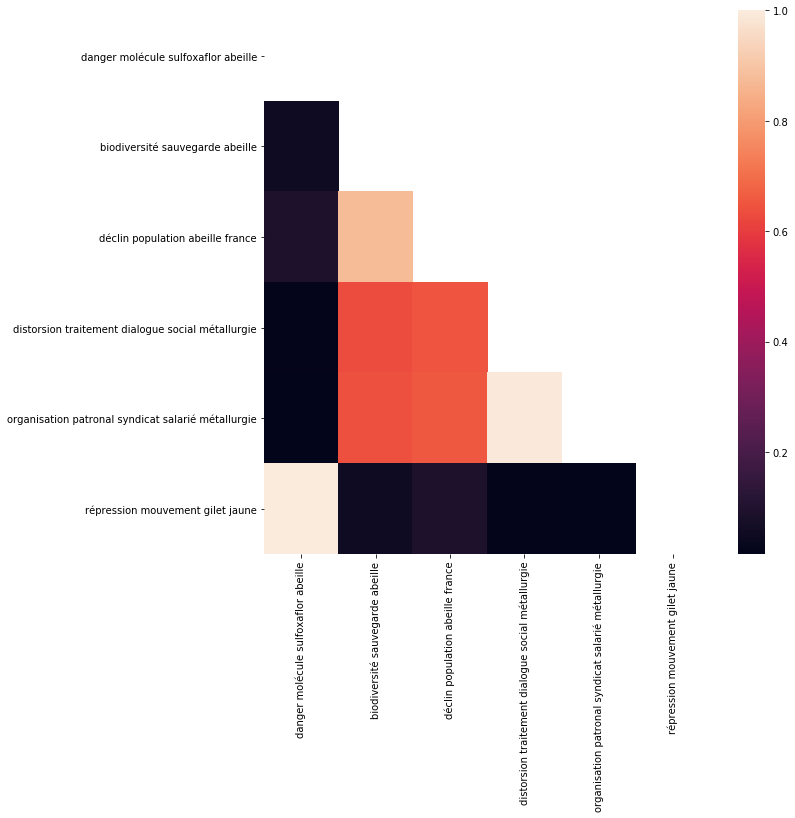

In [11]:
# On prend quelques questions sur les abeilles
index_abeilles = df.titre.str.contains('abeille')
abeilles = df[index_abeilles].question[:3]

# On prend quelques questions sur l'industrie
index_metal = df.titre.str.contains('métallurgie')
metal = df[index_metal].question[:2]

# Et une sur les gilets jaunes
index_jaune = df.titre.str.contains('gilet jaune')
jaune = df[index_jaune].question[:1]

question = list(abeilles) + list(metal) + list(jaune)
premiere_phrase = [q.split(' .')[0] for q in question]

mat = [[sim_sum_vec(a,b) for a in premiere_phrase] for b in premiere_phrase]

# Affichage
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(mat) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(mat,ax = ax,mask=mask, xticklabels=titres, yticklabels=titres);

## Remarques
* Résultat souvent incohérents
* Comment détecter la première phrase sans prendre ne compte le ministre ?
 * Unsupervised pour apprendre à clusteriser les premières phrases, puis supervised sur labélisés ?
